<a href="https://colab.research.google.com/github/fsemecurbe/AOTMS/blob/main/AOPTMSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apply Optimal transport to measure spatial segregation



In [6]:
!pip install POT
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.4 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import pandas as pd
import ot
import numpy as np

In [10]:
carreaux = gpd.read_parquet('/content/drive/MyDrive/aotms/carreaux_200m_met.parquet')
aav2020 = gpd.read_parquet('/content/drive/MyDrive/aotms/aav2020_2024.parquet')

In [11]:
aa = carreaux.sjoin(aav2020[aav2020.libaav2020 == "Besançon"].to_crs(carreaux.crs), how='inner')

In [27]:
aa = carreaux.cx[640036.075463 : 663665.414924,  6853996.452294 : 6872298.045911]

<Axes: >

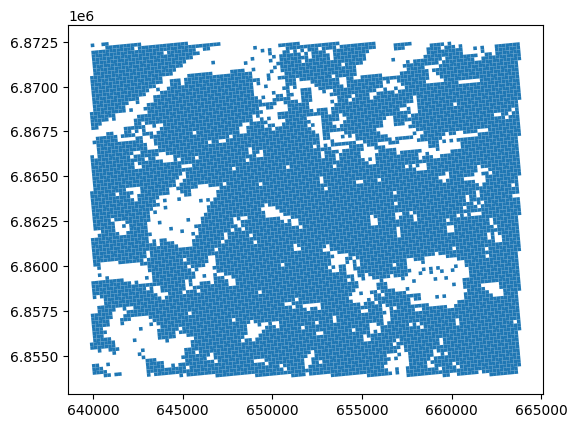

In [28]:
aa.plot()

In [29]:
aa['x'] = aa.geometry.centroid.x
aa['y'] = aa.geometry.centroid.y

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
aa_poor = aa.loc[aa.men_pauv>0 , ['x','y', 'men_pauv', 'geometry']].rename(columns={'men_pauv':'poor'})
aa['nonpoor'] = aa.men - aa.men_pauv
aa_nonpoor = aa.loc[aa.nonpoor>0  , ['x','y', 'nonpoor', 'geometry']]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [31]:
C = ot.dist(aa_nonpoor[['x', 'y']].to_numpy(), aa_poor[['x', 'y']].to_numpy())

In [32]:
poor = (aa_poor.poor / aa_poor.poor.sum()).to_numpy()
nonpoor = (aa_nonpoor.nonpoor / aa_nonpoor.nonpoor.sum()).to_numpy()

In [33]:
T = ot.emd(nonpoor , poor , C)

/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [34]:
np.sum(T * C)

3700101.3577868273

In [39]:
aa_poor['dist'] = np.sum(T * C, axis=0) / aa_poor.poor
aa_nonpoor['dist'] =   np.sum(T * C, axis=1) / aa_nonpoor.nonpoor

<Axes: >

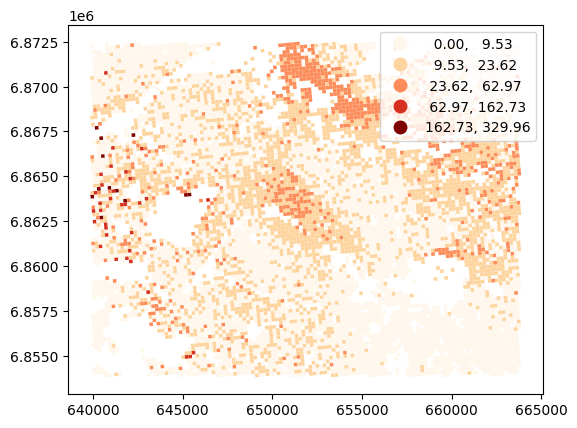

In [40]:
aa_poor.plot('dist', cmap='OrRd', scheme='fisherjenks', legend=True )

<Axes: >

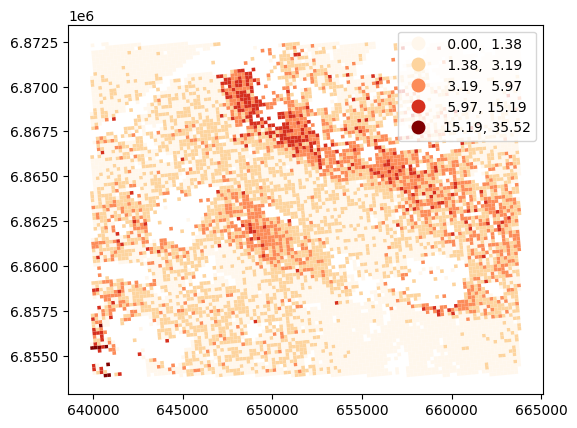

In [41]:
aa_nonpoor.plot('dist', cmap='OrRd', scheme='fisherjenks', legend=True )